In [1]:
from pathlib import Path

import cv2 as cv
import exposure_fusion as ef
import matplotlib.pyplot as plt
import numpy as np

from dhdrnet.util import DATA_DIR, ROOT_DIR

figdir = ROOT_DIR / "figures"

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


4KK2_20150910_151036_908.png

0037_20160716_115039_415.png

0094_20150412_110436_460.png


In [2]:
from random import sample

image_names = [
    "4KK2_20150910_151036_908",
    "0037_20160716_115039_415",
    "0094_20150412_110436_460",
    "33TJ_20150810_173750_121",
    "0009_20160710_122940_904",
    "33TJ_20150731_191218_412",
    "0830_20151120_140458_302",
    "6G7M_20150403_181933_693",
]
# image_names = [
#     p.stem
#     for p in sample(
#         list((DATA_DIR / "correct_exposures" / "ground_truth").iterdir()), k=5
#     )
# ]
exposure_files = [
    (DATA_DIR / "correct_exposures" / "exposures").glob(f"{name}*")
    for name in image_names
]

ev_list = [-4.0, -2.0, 0.0, 2.0, 4.0]
exposure_files = [
    [file for file in files if any(f"[{ev}]" in file.name for ev in ev_list)]
    for files in exposure_files
]
exposure_files
from dhdrnet.gen_pairs import GenAllPairs

generator = GenAllPairs(
    raw_path=DATA_DIR / "dngs",
    out_path=DATA_DIR / "correct_exposures",
    store_path=None,
    compute_scores=False,
)

In [3]:
loaded_image_groups = [
    [cv.imread(str(im_path)) for im_path in exp_group] for exp_group in exposure_files
]
weight_maps_per_image = [
    ef.compute_weights(images, None) for images in loaded_image_groups
]
fused_images = [generator.get_fused(name, ev_list=ev_list) for name in image_names]

/home/shane/.cache/pypoetry/virtualenvs/dhdrnet-md5k9ngR-py3.8/lib/python3.8/site-packages/colour/utilities/verbose.py:235: ColourWarning: "Adobe DNG Converter" is not available on your platform!
  warn(*args, **kwargs)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert imag

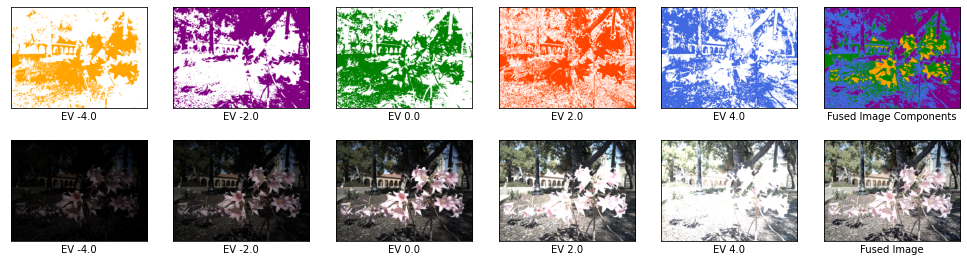

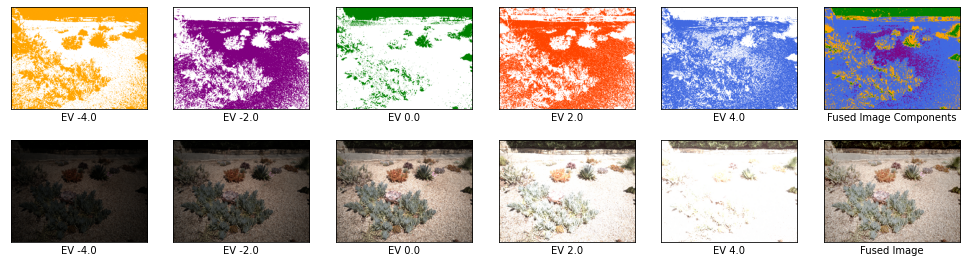

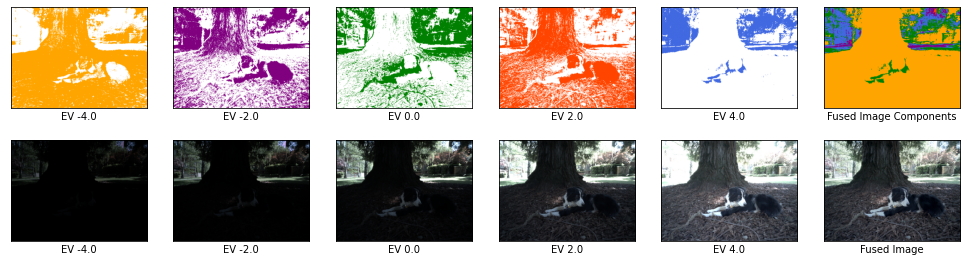

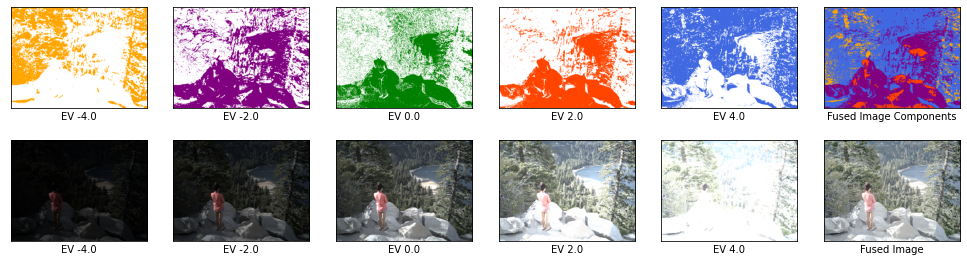

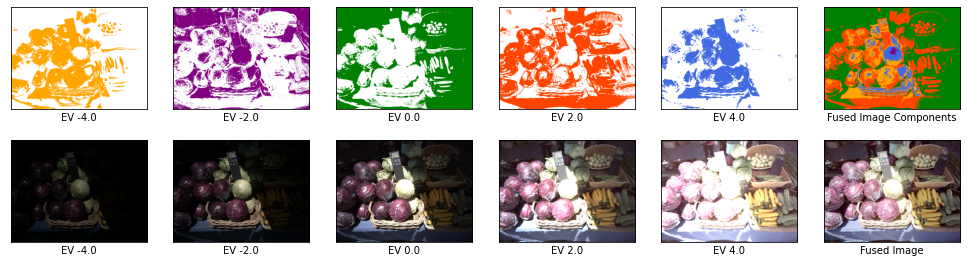

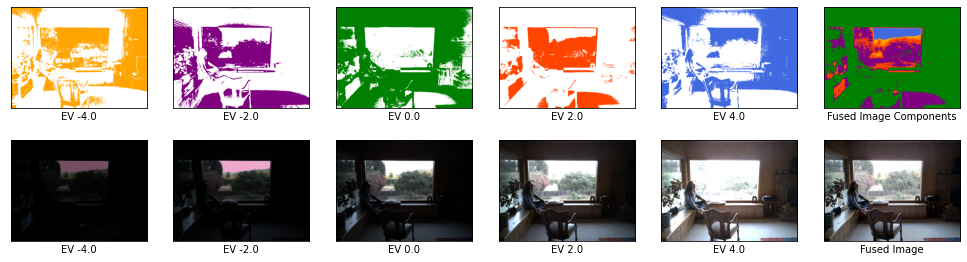

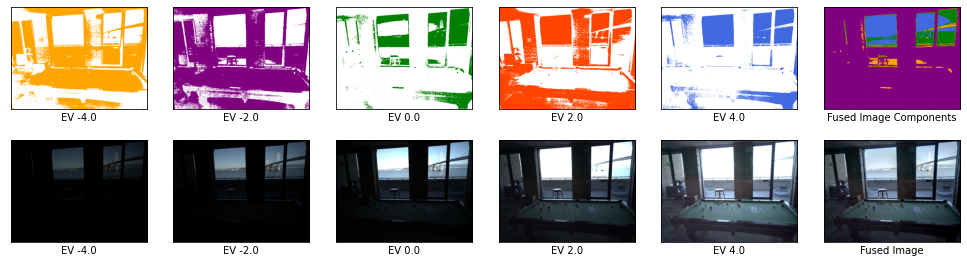

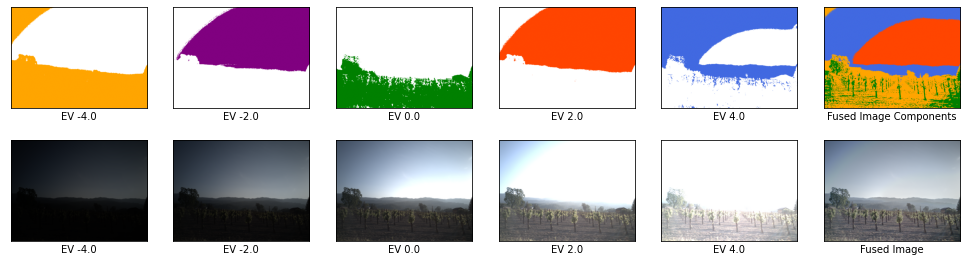

In [4]:
from more_itertools import one

from dhdrnet.vis_util import binarize_weights, recolour_image
# from PIL import Image
from skimage.io import imsave
from skimage.util import img_as_ubyte
from dhdrnet.util import dprint

binarized_wms = [[binarize_weights(wm) for wm in wms] for wms in weight_maps_per_image]
cmaps = ["orange", "purple", "green", "orangered", "royalblue"]
for weight_maps, fused, name in zip(weight_maps_per_image, fused_images, image_names):

    fig_namedir = figdir / "weight_maps" / name
    fig_namedir.mkdir(exist_ok=True)

    fig, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(14, 4))
    coloured_wms, fused_wm = recolour_image(weight_maps, cmaps)

    fig.tight_layout()
    for ev, wm, ax in zip(ev_list, coloured_wms, np.ravel(axs)):
        ax.imshow(
            wm,
            interpolation=None,
        )
        ax.set_xlabel(f"EV {ev}")
        ax.set_xticks([])
        ax.set_yticks([])
        imsave(fig_namedir / f"wm_{ev}.png",wm)
        
    exp_im_zip = zip(
        ev_list,
        generator.get_exposures(name, ev_list),
        np.ravel(axs)[1 + len(ev_list) :],
    )
    for ev, exp_im, ax in exp_im_zip:
        exp_im = exp_im[...,[2,1,0]]
        ax.imshow(exp_im)
        ax.set_xlabel(f"EV {ev}")
        ax.set_xticks([])
        ax.set_yticks([])

        imsave(fig_namedir / f"img_{ev}.png", img_as_ubyte(exp_im))

    axs[0, 5].imshow(fused_wm)
    axs[0, 5].set_xlabel("Fused Image Components")
    axs[0, 5].set_xticks([])
    axs[0, 5].set_yticks([])
    imsave(fig_namedir / "fused_weightmaps.png", fused_wm)

    axs[1, 5].imshow(fused[..., [2, 1, 0]])
    axs[1, 5].set_xlabel("Fused Image")
    axs[1, 5].set_xticks([])
    axs[1, 5].set_yticks([])

    
    fig.savefig(figdir / "weight_maps" / f"wm_fused_colours_{name}.pdf")